#  Convolutional NN it for facial keypoints recognition

Here I will build a convolutional neural network, and train it for the task of facial keypoints recognition. The data are obtained from Kaggle: **LINK**, and consists of **info**.

I will build the CNN using tensorflow **link**. 

##  Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

##  Reading the data

In [2]:
training_data = pd.read_csv('training.csv')
#training_data.info()

In [3]:
# I am working in a machine with too litlle memory, so in order to write the code I will use a smaller subset 
# of the data, limited to 1000 images randomly chosen. 

training_data = training_data.sample(n = 20, random_state=42) #setting a random state for reproducibility.
#training_data.info() # Check the new dataframe

In [4]:
# Making dataframes with the images and keypoints positions separately.

keypoints = training_data.drop('Image', axis = 1)
# The images are given as strings. I will cast them as arrays.
images = training_data['Image'].apply(lambda str_pic: np.array([int(px) for px in str_pic.split()]))

In [6]:
# images is now a Series, and each entry has an array encoding the image. The elements of the image
# are int64.

print( 'An image of the shape: ', images.iloc[0].shape)
print( 'Each pixel is ', images.iloc[0].dtype)

An image of the shape:  (9216,)
Each pixel is  int64


##  Visualizing the images.

Each image can be reshaped as a 96 x 96 array. We plot a random selection of images and their keypoints.

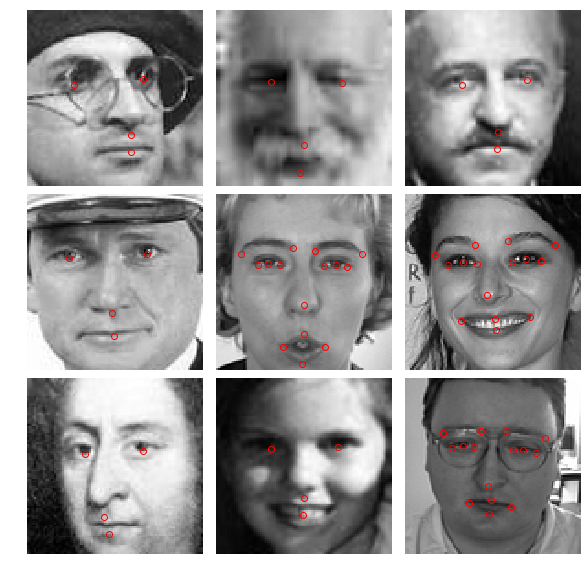

In [5]:
# Plotting faces with features

grid_size = 3

sample_images = images.sample(grid_size**2).index


fig, axes = plt.subplots(grid_size, grid_size, gridspec_kw = dict(hspace = .05, wspace = .05), 
                         figsize=(10,10))

for i, ax in zip(sample_images, axes.flat):

    ax.axis('off')
    # Plotting the faces
    ax.imshow(images[i].reshape(96,96),cmap='gist_gray')

    # Obtaining keypoints positions. x and y coordinates are even and odd indices respectively. 
    x_points = [keypoints.loc[i][j] for j in range(0,30,2)]
    y_points = [keypoints.loc[i][j+1] for j in range(0,30,2)]
    #plotting keypoints
    ax.plot(x_points, y_points, 'ro', markerfacecolor = 'none')    


##  Missing keypoints

As we can see, most images do not have all 15 keypoints labelled. This will come into play when writting the loss function for our Neural network. For the moment let us see how many keypoints of each we have. 

In [7]:
# Making new columns names by removing the subindices. 
new_col_list = [keypoints.columns[i][:-2] for i in range(0,len(keypoints.columns),2)]

# a dataframe saying which keypoints are marked on each image. 
present_keypoints = pd.DataFrame(columns = new_col_list)

for col in new_col_list:
    present_keypoints[col] = pd.notnull(keypoints[col+'_x'])
    
present_keypoints['Total'] = present_keypoints.sum(axis = 1)
print('Labelled \nkeypoints ', 'Images')
present_keypoints['Total'].value_counts()

Labelled 
keypoints  Images


4     663
15    314
14     10
13      5
11      3
3       3
10      1
8       1
Name: Total, dtype: int64

It is also important to notice that not all not all images with a certain quantity of keypoints have the same ones missing. For example, this is the case of images with 14 labelled keypoints.

In [8]:
num_keypoints = 14
binary_df = present_keypoints[present_keypoints['Total'] == num_keypoints].drop('Total', axis = 1).astype(np.int32)

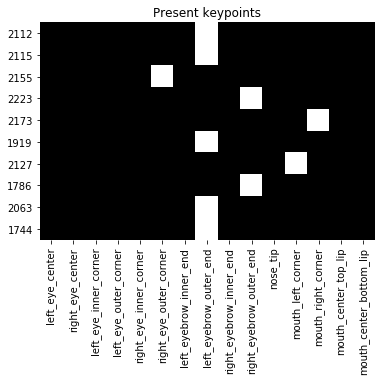

In [9]:
sns.heatmap(binary_df, yticklabels=True ,cbar=False,cmap='gist_gray_r')
plt.title('Present keypoints');

# Building the CNN

I will start by using the same architechture I used in the course.For the moment I will use train_test_split to test my network a bit. Eventually this wont be necessary, as the dataset provides a separate test set. 

In [6]:
# First I will reshape all images to 96 x 96

images = images.apply(lambda arr: arr.reshape((96,96,1)));
images.iloc[0].shape

(96, 96, 1)

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(images, keypoints, test_size=0.3, random_state=42)

In [10]:
import tensorflow as tf

In [11]:
#Some helping functions.
def init_weights(shape):
    init_random_dist = tf.random_normal(shape, stddev=0.1) # Why this stddev?
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.random_uniform(shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b


In [12]:
# PLACEHOLDERS

x = tf.placeholder(tf.float32, [None, 96, 96, 1])
keypoints_true = tf.placeholder(tf.float32, [None, 30])

In [13]:
# LAYERS

convo1 = convolutional_layer(x, [8,8,1,32]) # 8 x 8 filter, 1 channel in, 32 channels out. SAME padding.
                                            # so output images are also 96 x 96. 
convo1_pool = max_pool_2by2(convo1)

In [14]:
convo2 = convolutional_layer(convo1_pool, [4,4,32,64]) # 4x4 filter, 64 outputs. SAME padding.
convo2_pool = max_pool_2by2(convo2) #24 x 24 x 64

In [15]:
convo3 = convolutional_layer(convo2_pool, [4,4,64,128]) # 4x4 filter, 64 outputs. SAME padding.
convo3_pool = max_pool_2by2(convo3) # 12 x 12 x 128

In [16]:
convo3_flat = tf.reshape(convo3_pool,[-1,12*12*128])
full_layer_one = tf.nn.relu(normal_full_layer(convo3_flat,1024))

In [17]:
# DROPOUT AND OUTPOUT LAYER
hold_prob = tf.placeholder(tf.float32)
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)

keypoints_pred = normal_full_layer(full_one_dropout,30)

In [18]:
# LOSS FUNCTION

masked_loss = tf.reduce_mean(tf.square(
        tf.boolean_mask(keypoints_pred-keypoints_true, tf.is_finite(keypoints_true) )
    ))


optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(masked_loss)

/home/ubuntu/anaconda3/envs/tensor/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [19]:
# INITIALIZER

init = tf.global_variables_initializer()

In [20]:
saver = tf.train.Saver()

In [21]:
counter = 0

In [22]:
# Trying a different data format.

X_train_array = np.array([X_train.iloc[i] for i in range(5)])
y_train_array = np.array([y_train.iloc[i] for i in range(5)])

X_test_array = np.array([X_test.iloc[i] for i in range(5)])
y_test_array = np.array([y_test.iloc[i] for i in range(5)])

In [23]:
X_train_array.shape

(5, 96, 96, 1)

In [ ]:
num_steps = 40

with tf.Session() as sess:
    
    sess.run(init)
    
    for iteration in range(num_steps+1):
        
        x_batch, keypoints_batch = X_train_array, y_train_array
        x_test, keypoints_test = X_test_array, y_test_array
        
        sess.run(train, feed_dict={x: x_batch, keypoints_true: keypoints_batch, hold_prob: 0.5})
        
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%10 == 0:
            
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            # Test the Train Model
            
            print(sess.run(masked_loss,feed_dict={x:x_test,keypoints_true:keypoints_test,hold_prob:1.0}))
            print('\n')
    
    saver.save(sess, "./keypoints_cnn_" + str(counter) )